#### Experimenting with Facebook Prophet tool to predict future sales using data from 1115 unique stores of a company.

Data Source: https://www.kaggle.com/c/rossmann-store-sales/data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

In [2]:
sales_train_df = pd.read_csv('train.csv')
sales_store_df = pd.read_csv("store.csv")


C:\Users\iamni\AppData\Local\Temp\ipykernel_13832\3339906211.py:1: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  sales_train_df = pd.read_csv('train.csv')


In [3]:
sales_train_df.info()
# almost a million observation 
# 1115 unique stores 
# Note that sales is the target variable (that's what we are trying to predict) 

# Id: transaction ID (combination of Store and date) 
# Store: unique store Id
# Sales: sales/day, this is the target variable 
# Customers: number of customers on a given day
# Open: Boolean to say whether a store is open or closed (0 = closed, 1 = open)
# Promo: describes if store is running a promo on that day or not
# StateHoliday: indicate which state holiday (a = public holiday, b = Easter holiday, c = Christmas, 0 = None)
# SchoolHoliday: indicates if the (Store, Date) was affected by the closure of public schools

#- Data Source: https://www.kaggle.com/c/rossmann-store-sales/data


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 9 columns):
 #   Column         Non-Null Count    Dtype 
---  ------         --------------    ----- 
 0   Store          1017209 non-null  int64 
 1   DayOfWeek      1017209 non-null  int64 
 2   Date           1017209 non-null  object
 3   Sales          1017209 non-null  int64 
 4   Customers      1017209 non-null  int64 
 5   Open           1017209 non-null  int64 
 6   Promo          1017209 non-null  int64 
 7   StateHoliday   1017209 non-null  object
 8   SchoolHoliday  1017209 non-null  int64 
dtypes: int64(7), object(2)
memory usage: 69.8+ MB


In [4]:
sales_train_df.describe()
# Average sales amount per day = 5773 Euros, minimum sales per day = 0, maximum sales per day = 41551 
# Average number of customers = 633, minimum number of customers = 0, maximum number of customers = 7388

,Store,DayOfWeek,Sales,Customers,Open,Promo,SchoolHoliday
count,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06
mean,5.584297e+02,3.998341e+00,5.773819e+03,6.331459e+02,8.301067e-01,3.815145e-01,1.786467e-01
std,3.219087e+02,1.997391e+00,3.849926e+03,4.644117e+02,3.755392e-01,4.857586e-01,3.830564e-01
min,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,2.800000e+02,2.000000e+00,3.727000e+03,4.050000e+02,1.000000e+00,0.000000e+00,0.000000e+00
50%,5.580000e+02,4.000000e+00,5.744000e+03,6.090000e+02,1.000000e+00,0.000000e+00,0.000000e+00
75%,8.380000e+02,6.000000e+00,7.856000e+03,8.370000e+02,1.000000e+00,1.000000e+00,0.000000e+00
max,1.115000e+03,7.000000e+00,4.155100e+04,7.388000e+03,1.000000e+00,1.000000e+00,1.000000e+00


In [5]:
sales_store_df.info()
# StoreType: categorical variable to indicate type of store (a, b, c, d)
# Assortment: describes an assortment level: a = basic, b = extra, c = extended
# CompetitionDistance (meters): distance to closest competitor store
# CompetitionOpenSince [Month/Year]: provides an estimate of the date when competition was open
# Promo2: Promo2 is a continuing and consecutive promotion for some stores (0 = store is not participating, 1 = store is participating)
# Promo2Since [Year/Week]: date when the store started participating in Promo2
# PromoInterval: describes the consecutive intervals Promo2 is started, naming the months the promotion is started anew. E.g. "Feb,May,Aug,Nov" means each round starts in February, May, August, November of any given year for that store


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Store                      1115 non-null   int64  
 1   StoreType                  1115 non-null   object 
 2   Assortment                 1115 non-null   object 
 3   CompetitionDistance        1112 non-null   float64
 4   CompetitionOpenSinceMonth  761 non-null    float64
 5   CompetitionOpenSinceYear   761 non-null    float64
 6   Promo2                     1115 non-null   int64  
 7   Promo2SinceWeek            571 non-null    float64
 8   Promo2SinceYear            571 non-null    float64
 9   PromoInterval              571 non-null    object 
dtypes: float64(5), int64(2), object(3)
memory usage: 87.2+ KB


In [6]:
sales_store_df.describe()


,Store,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear
count,1115.00000,1112.000000,761.000000,761.000000,1115.000000,571.000000,571.000000
mean,558.00000,5404.901079,7.224704,2008.668857,0.512108,23.595447,2011.763573
std,322.01708,7663.174720,3.212348,6.195983,0.500078,14.141984,1.674935
min,1.00000,20.000000,1.000000,1900.000000,0.000000,1.000000,2009.000000
25%,279.50000,717.500000,4.000000,2006.000000,0.000000,13.000000,2011.000000
50%,558.00000,2325.000000,8.000000,2010.000000,1.000000,22.000000,2012.000000
75%,836.50000,6882.500000,10.000000,2013.000000,1.000000,37.000000,2013.000000
max,1115.00000,75860.000000,12.000000,2015.000000,1.000000,50.000000,2015.000000


#### Data Exploration 
 for sales_train data

<Axes: >

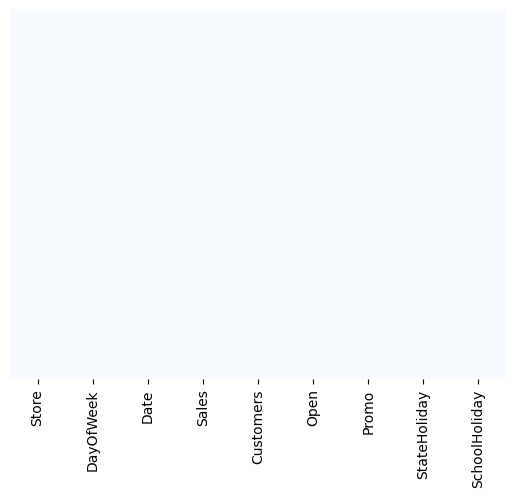

In [7]:
# checking for mising data.
sns.heatmap(sales_train_df.isnull(), yticklabels = False, cbar = False, cmap = 'Blues')

array([[<Axes: title={'center': 'Store'}>,
        <Axes: title={'center': 'DayOfWeek'}>,
        <Axes: title={'center': 'Sales'}>],
       [<Axes: title={'center': 'Customers'}>,
        <Axes: title={'center': 'Open'}>,
        <Axes: title={'center': 'Promo'}>],
       [<Axes: title={'center': 'SchoolHoliday'}>, <Axes: >, <Axes: >]],
      dtype=object)

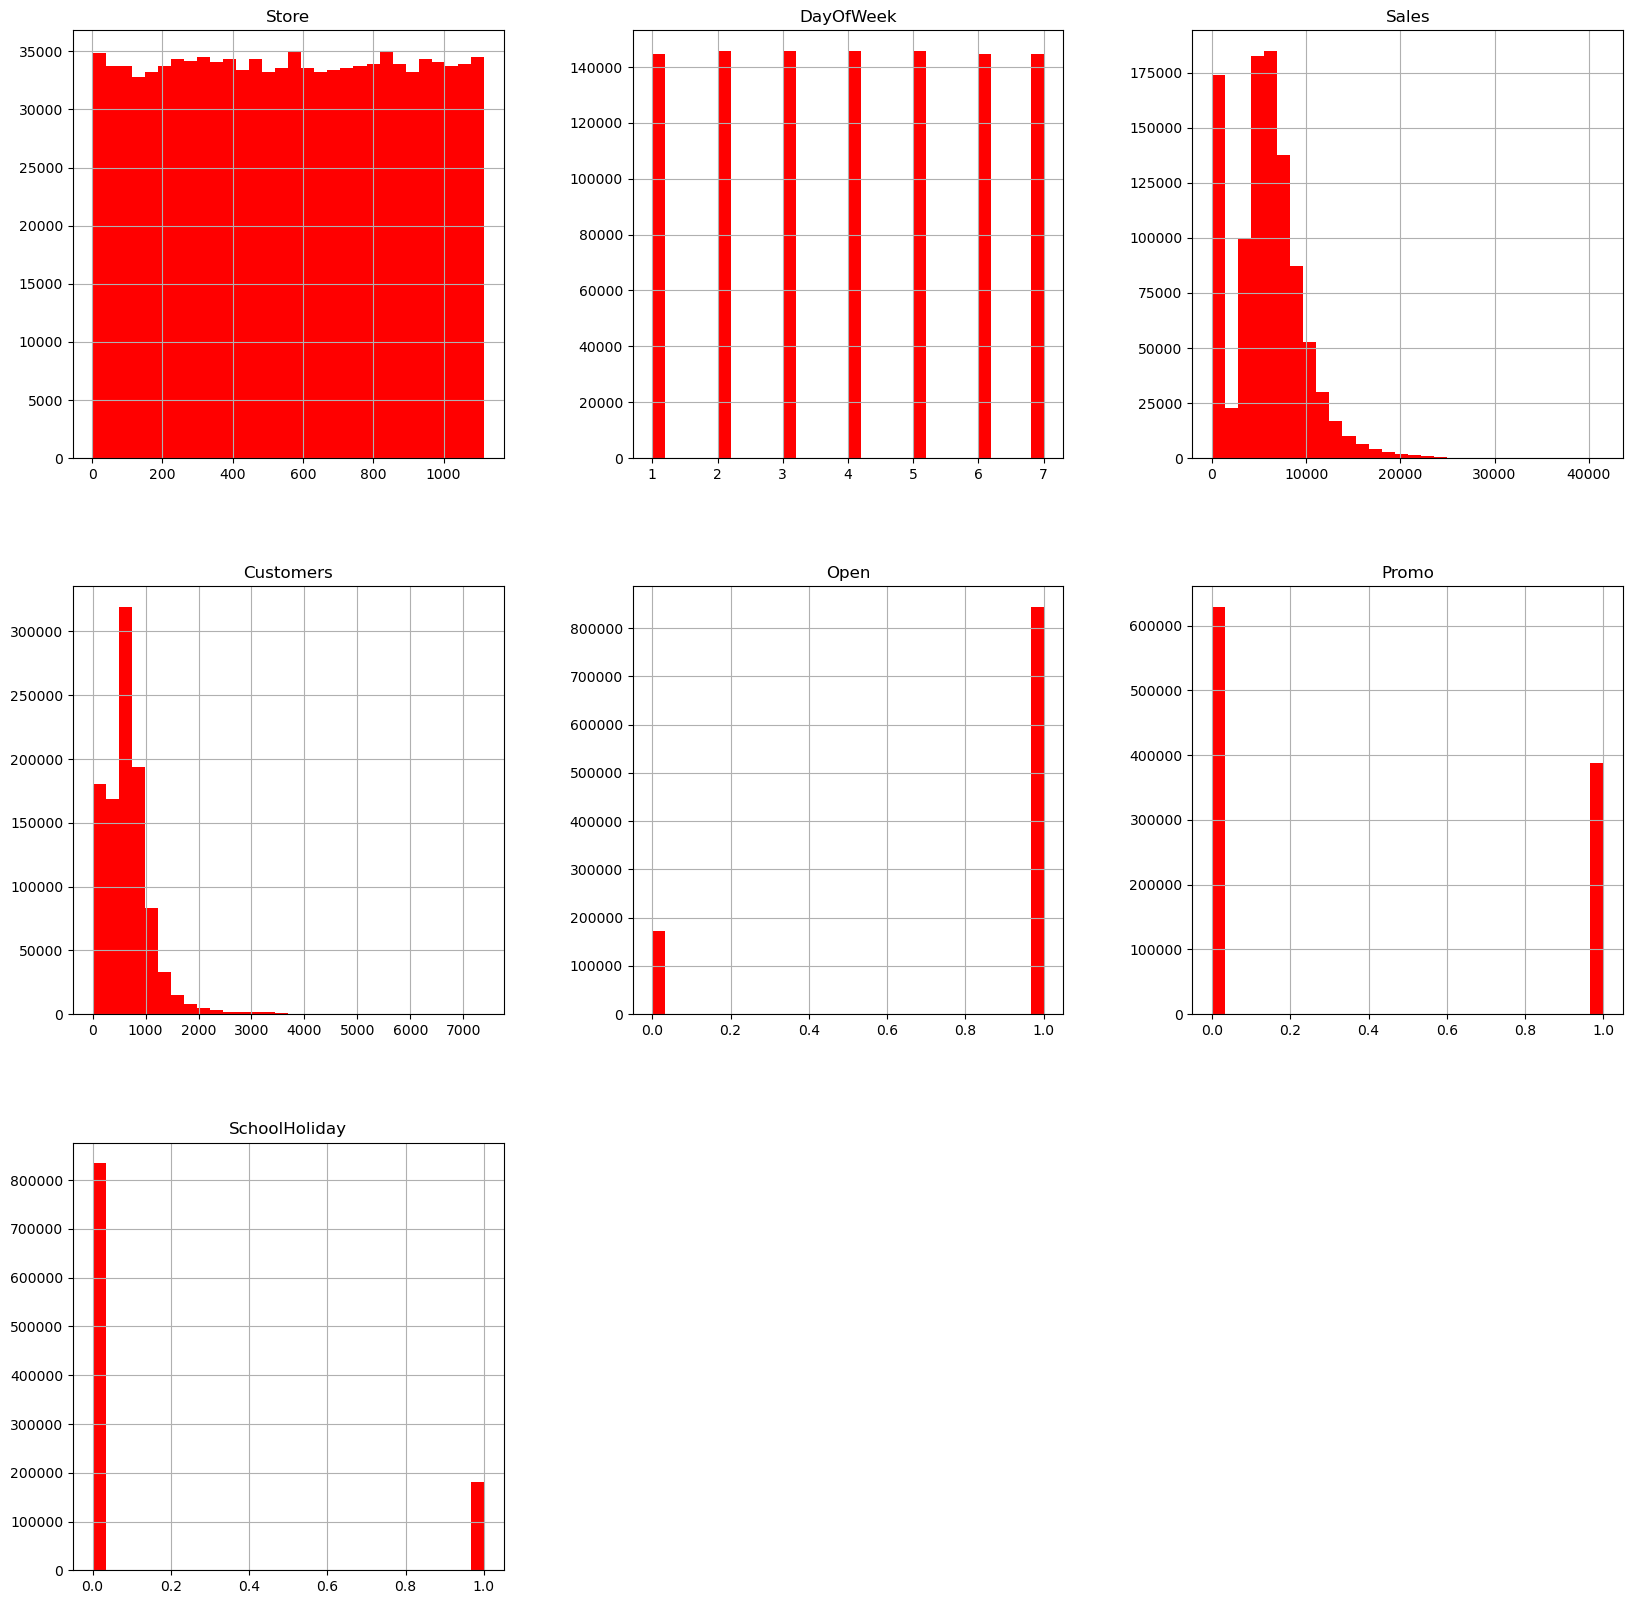

In [8]:
sales_train_df.hist(bins = 30, figsize = (20, 20), color = 'r')

In [9]:
#How many stores are open or closed
closed_train_df = sales_train_df[sales_train_df['Open'] == 0]
open_train_df = sales_train_df[sales_train_df['Open'] == 1]

In [10]:
print('Total stores:', len(sales_train_df))
print('Number of closed stores:', len(closed_train_df))
print('Number of open stores:', len(open_train_df))

Total stores: 1017209
Number of closed stores: 172817
Number of open stores: 844392


In [11]:
#droping all closed stores
sales_train_df = open_train_df
sales_train_df.drop(['Open'], axis = 1, inplace = True)


#### Data exploration 
for store data

<Axes: >

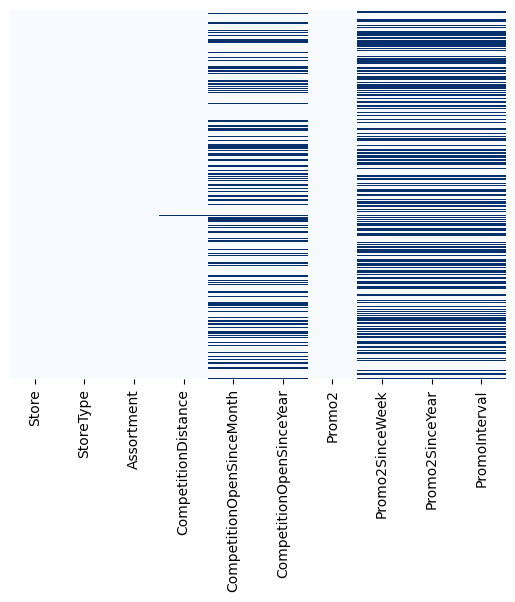

In [12]:
# checking for missing values
sns.heatmap(sales_store_df.isnull(), yticklabels = False, cbar = False, cmap = 'Blues')

In [13]:
sales_store_df[sales_store_df['CompetitionDistance'].isnull()]

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
290,291,d,a,NaN,NaN,NaN,0,NaN,NaN,NaN
621,622,a,c,NaN,NaN,NaN,0,NaN,NaN,NaN
878,879,d,a,NaN,NaN,NaN,1,5.0,2013.0,"Feb,May,Aug,Nov"


In [14]:
sales_store_df[sales_store_df['CompetitionOpenSinceMonth'].isnull()]

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
11,12,a,c,1070.0,NaN,NaN,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
12,13,d,a,310.0,NaN,NaN,1,45.0,2009.0,"Feb,May,Aug,Nov"
15,16,a,c,3270.0,NaN,NaN,0,NaN,NaN,NaN
18,19,a,c,3240.0,NaN,NaN,1,22.0,2011.0,"Mar,Jun,Sept,Dec"
21,22,a,a,1040.0,NaN,NaN,1,22.0,2012.0,"Jan,Apr,Jul,Oct"
...,...,...,...,...,...,...,...,...,...,...
1095,1096,a,c,1130.0,NaN,NaN,1,10.0,2014.0,"Mar,Jun,Sept,Dec"
1099,1100,a,a,540.0,NaN,NaN,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
1112,1113,a,c,9260.0,NaN,NaN,0,NaN,NaN,NaN
1113,1114,a,c,870.0,NaN,NaN,0,NaN,NaN,NaN


In [15]:
#fillining all missing values with 0 in following as nan is due to absence of promo2 on observation
str_cols = ['Promo2SinceWeek', 'Promo2SinceYear','PromoInterval',
            'CompetitionOpenSinceYear','CompetitionOpenSinceMonth']
for columns in str_cols:
    sales_store_df[columns].fillna(0, inplace = True)

In [16]:
#filling rest nan with their median
sales_store_df['CompetitionDistance'].fillna(sales_store_df['CompetitionDistance'].median(), inplace = True)

<Axes: >

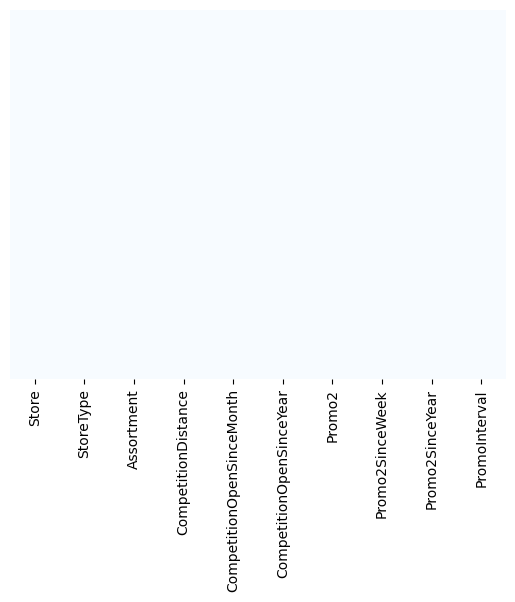

In [17]:
sns.heatmap(sales_store_df.isnull(), yticklabels = False, cbar = False, cmap = 'Blues')

array([[<Axes: title={'center': 'Store'}>,
        <Axes: title={'center': 'CompetitionDistance'}>,
        <Axes: title={'center': 'CompetitionOpenSinceMonth'}>],
       [<Axes: title={'center': 'CompetitionOpenSinceYear'}>,
        <Axes: title={'center': 'Promo2'}>,
        <Axes: title={'center': 'Promo2SinceWeek'}>],
       [<Axes: title={'center': 'Promo2SinceYear'}>, <Axes: >, <Axes: >]],
      dtype=object)

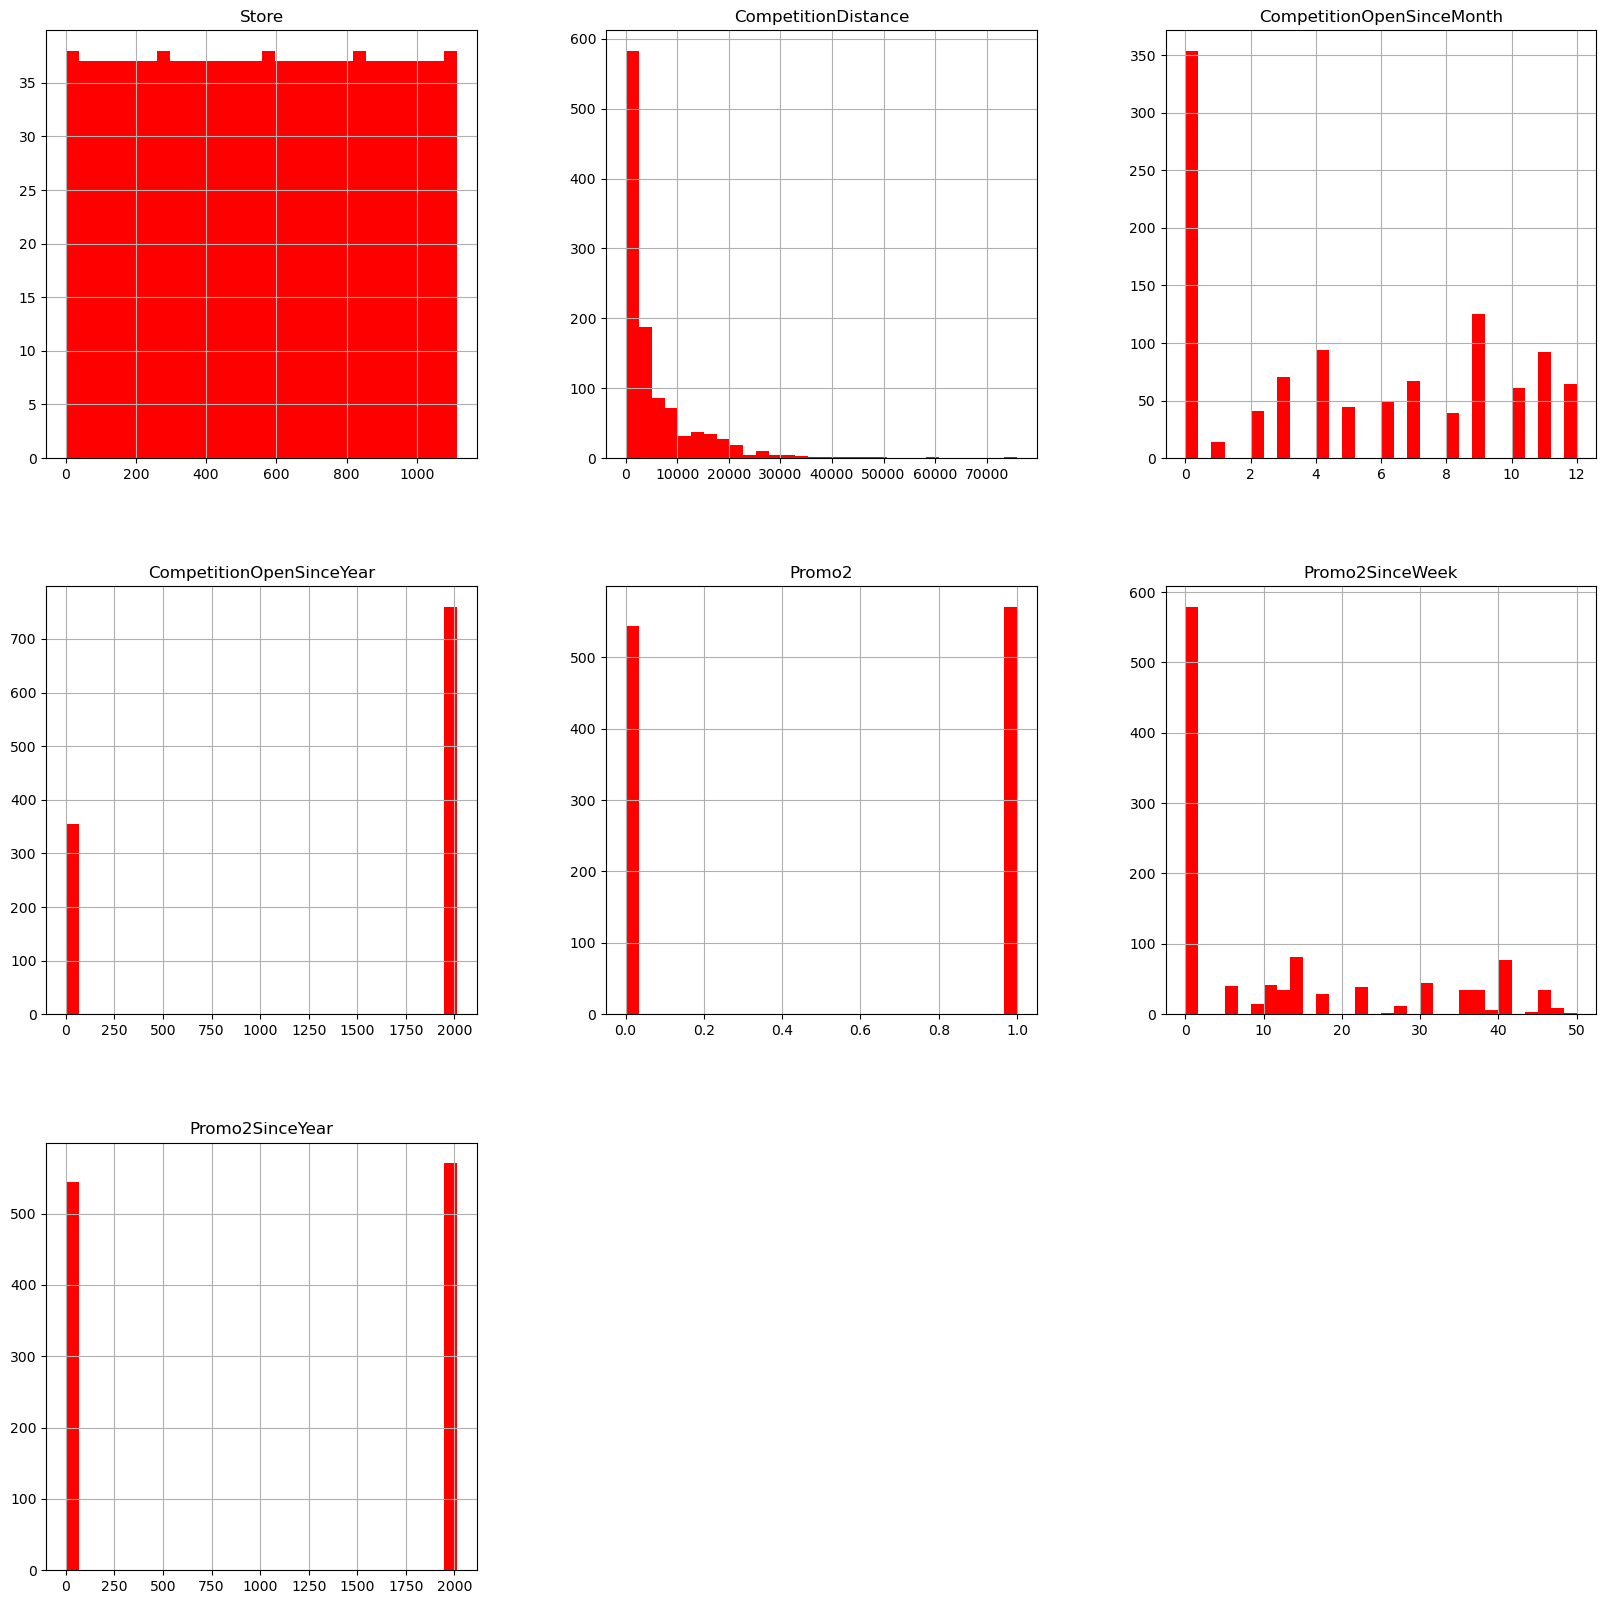

In [18]:
 sales_store_df.hist(bins = 30, figsize = (20, 20), color = 'r')
    # half of stores are involved in promo 2
# half of the stores have their competition at a distance of 0-3000m (3 kms away)

In [19]:
#merging both data frames
sales_df = pd.merge(sales_train_df,  sales_store_df, how = 'inner', on = 'Store')

In [20]:
sales_df

,Store,DayOfWeek,Date,Sales,Customers,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
1,1,4,2015-07-30,5020,546,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
2,1,3,2015-07-29,4782,523,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
3,1,2,2015-07-28,5011,560,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
4,1,1,2015-07-27,6102,612,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
844387,292,1,2013-01-07,9291,1002,1,0,0,a,a,1100.0,6.0,2009.0,0,0.0,0.0,0
844388,292,6,2013-01-05,2748,340,0,0,0,a,a,1100.0,6.0,2009.0,0,0.0,0.0,0
844389,292,5,2013-01-04,4202,560,0,0,1,a,a,1100.0,6.0,2009.0,0,0.0,0.0,0
844390,292,4,2013-01-03,4580,662,0,0,1,a,a,1100.0,6.0,2009.0,0,0.0,0.0,0


In [21]:
#checking correlation in data
correlation = sales_df.corr()['Sales'].sort_values()
correlation
# customers and promo are positively correlated with the sales 
# Promo2 does not seem to be effective at all 

C:\Users\iamni\AppData\Local\Temp\ipykernel_13832\2521011022.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation = sales_df.corr()['Sales'].sort_values()


DayOfWeek                   -0.178736
Promo2SinceYear             -0.127621
Promo2                      -0.127596
Promo2SinceWeek             -0.058476
CompetitionDistance         -0.035851
CompetitionOpenSinceMonth   -0.018370
CompetitionOpenSinceYear     0.005266
Store                        0.007710
SchoolHoliday                0.038617
Promo                        0.368145
Customers                    0.823597
Sales                        1.000000
Name: Sales, dtype: float64

C:\Users\iamni\AppData\Local\Temp\ipykernel_13832\2853203918.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation = sales_df.corr()


<Axes: >

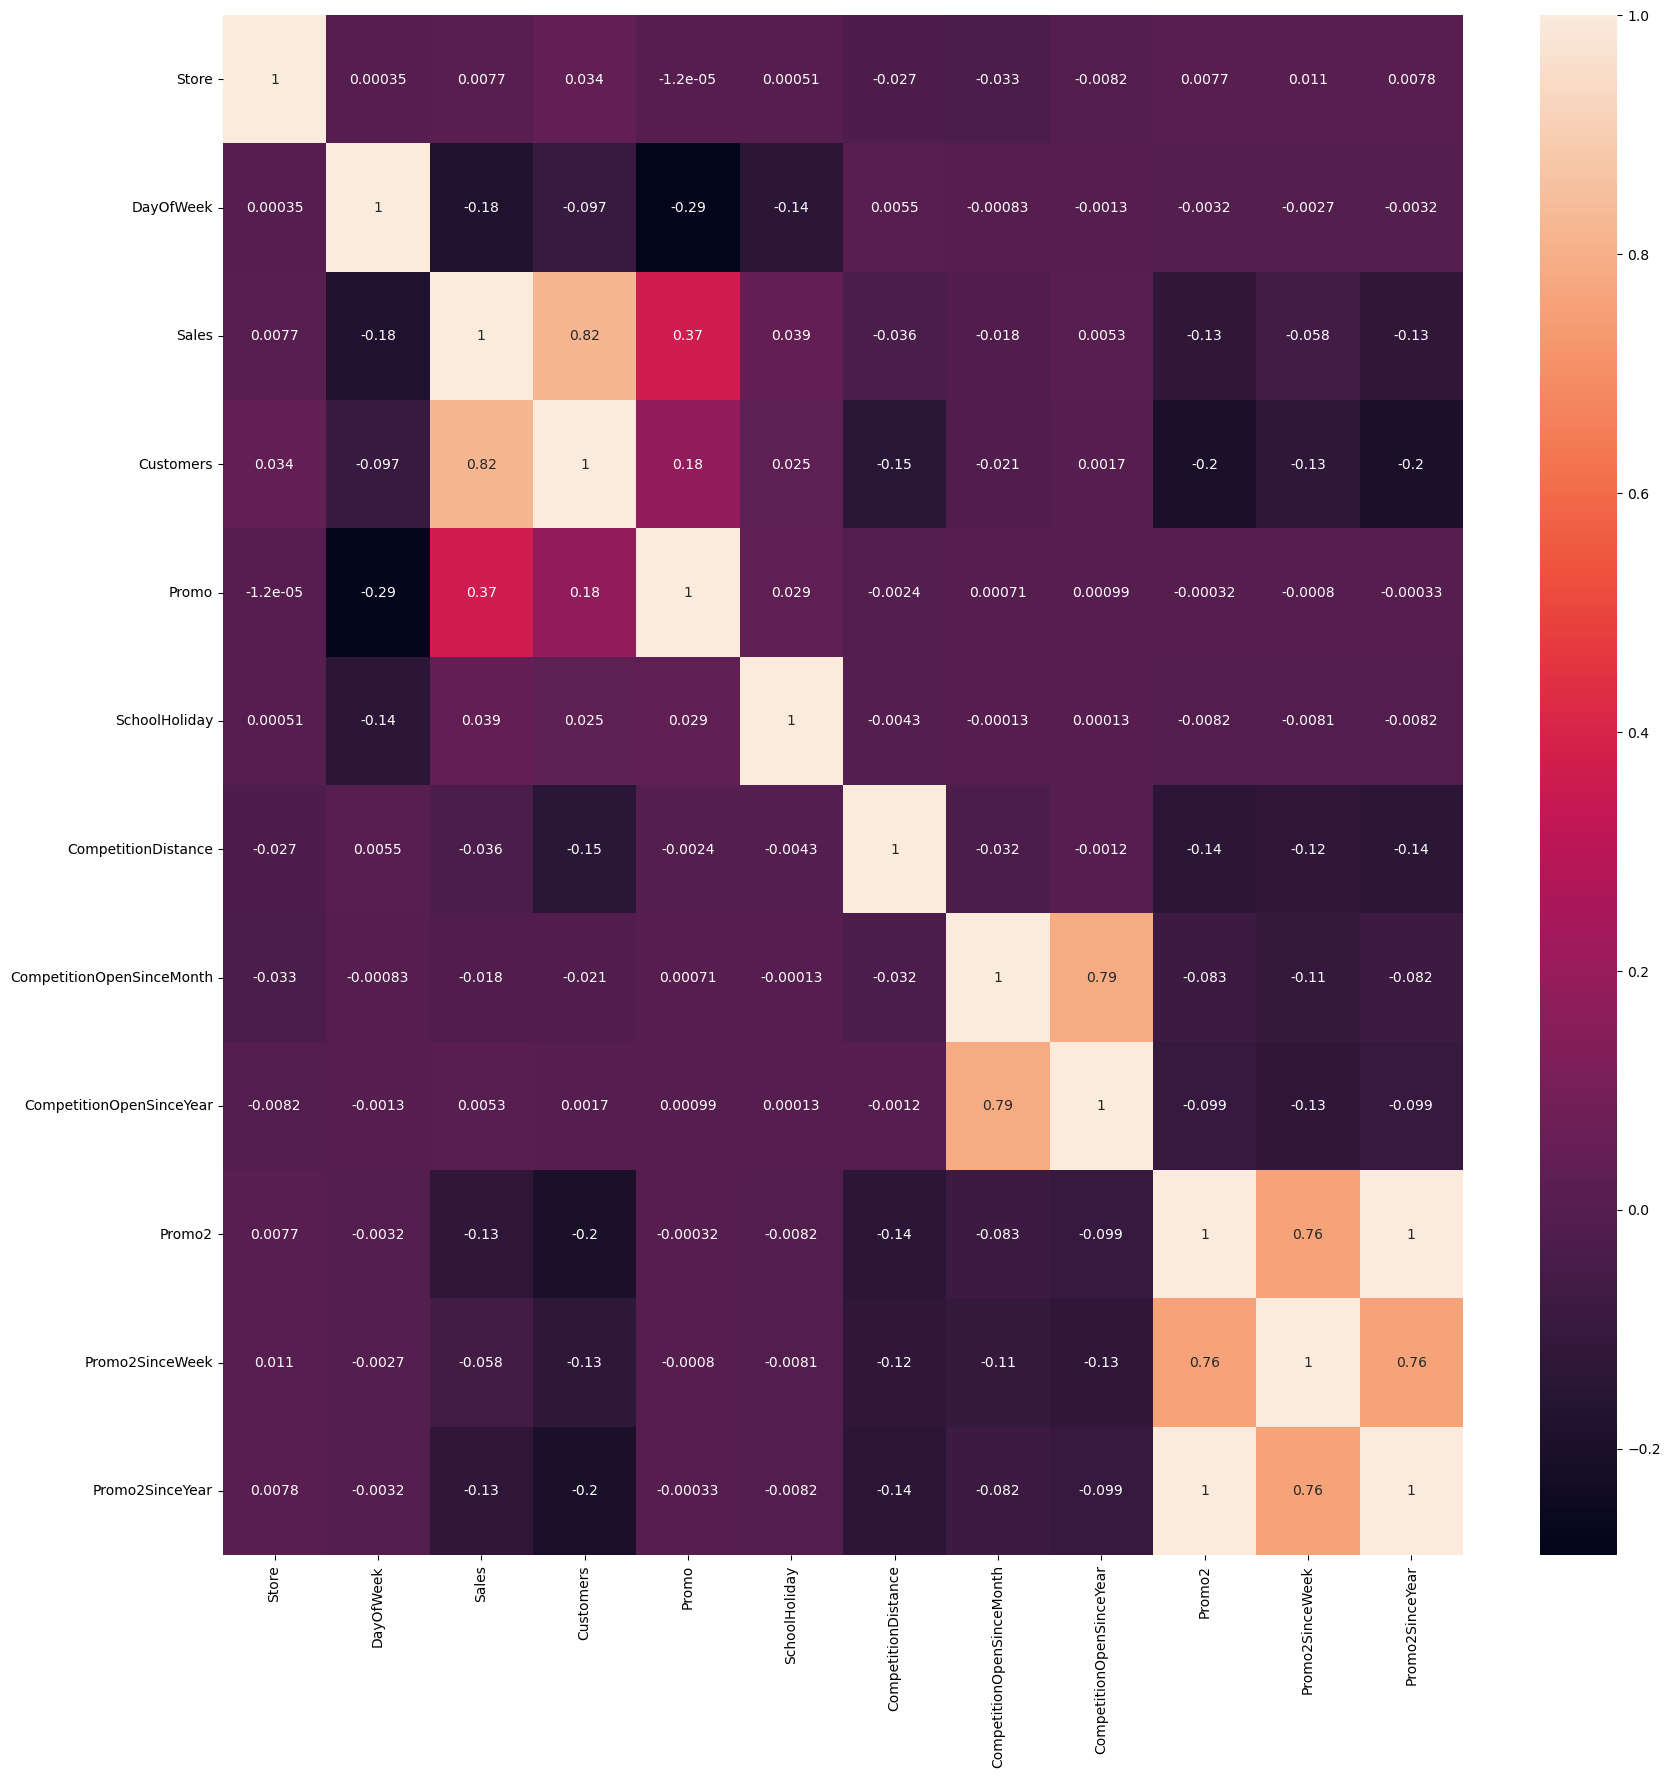

In [22]:
correlation = sales_df.corr()
f, ax = plt.subplots(figsize = (20,20))
sns.heatmap(correlation, annot = True)

In [23]:
#seprating datetime
sales_df['Year'] = pd.DatetimeIndex(sales_df['Date']).year
sales_df['Month'] = pd.DatetimeIndex(sales_df['Date']).month
sales_df['Day'] = pd.DatetimeIndex(sales_df['Date']).day
sales_df['DayofWeek'] = pd.DatetimeIndex(sales_df['Date']).dayofweek
sales_df

,Store,DayOfWeek,Date,Sales,Customers,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,...,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Year,Month,Day,DayofWeek
0,1,5,2015-07-31,5263,555,1,0,1,c,a,...,9.0,2008.0,0,0.0,0.0,0,2015,7,31,4
1,1,4,2015-07-30,5020,546,1,0,1,c,a,...,9.0,2008.0,0,0.0,0.0,0,2015,7,30,3
2,1,3,2015-07-29,4782,523,1,0,1,c,a,...,9.0,2008.0,0,0.0,0.0,0,2015,7,29,2
3,1,2,2015-07-28,5011,560,1,0,1,c,a,...,9.0,2008.0,0,0.0,0.0,0,2015,7,28,1
4,1,1,2015-07-27,6102,612,1,0,1,c,a,...,9.0,2008.0,0,0.0,0.0,0,2015,7,27,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
844387,292,1,2013-01-07,9291,1002,1,0,0,a,a,...,6.0,2009.0,0,0.0,0.0,0,2013,1,7,0
844388,292,6,2013-01-05,2748,340,0,0,0,a,a,...,6.0,2009.0,0,0.0,0.0,0,2013,1,5,5
844389,292,5,2013-01-04,4202,560,0,0,1,a,a,...,6.0,2009.0,0,0.0,0.0,0,2013,1,4,4
844390,292,4,2013-01-03,4580,662,0,0,1,a,a,...,6.0,2009.0,0,0.0,0.0,0,2013,1,3,3


Text(0.5, 1.0, 'Average Customers per day')

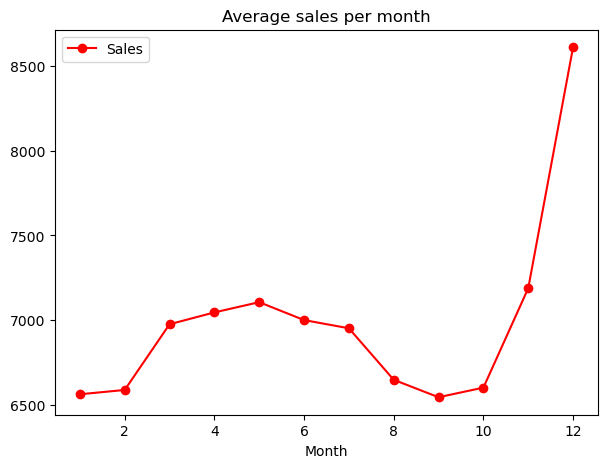

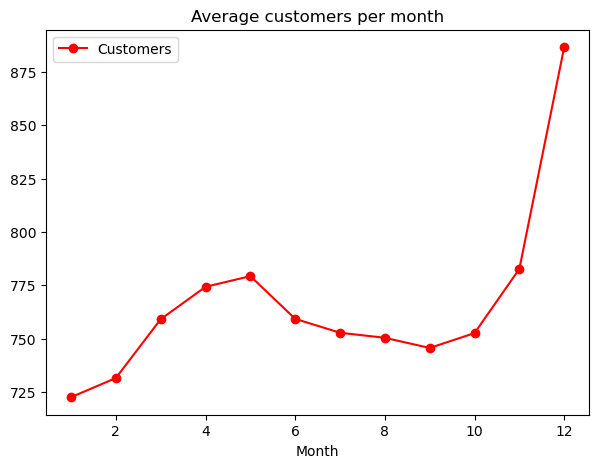

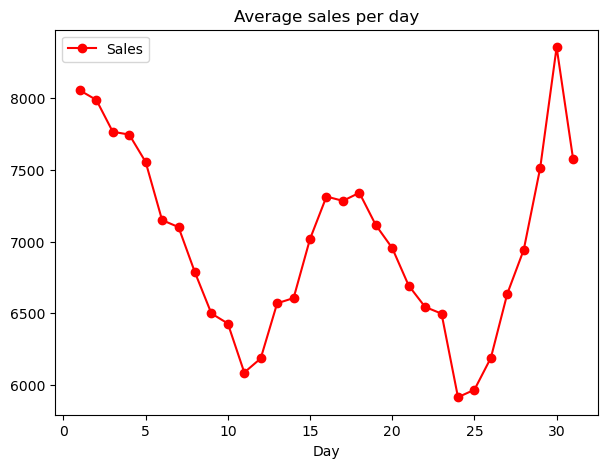

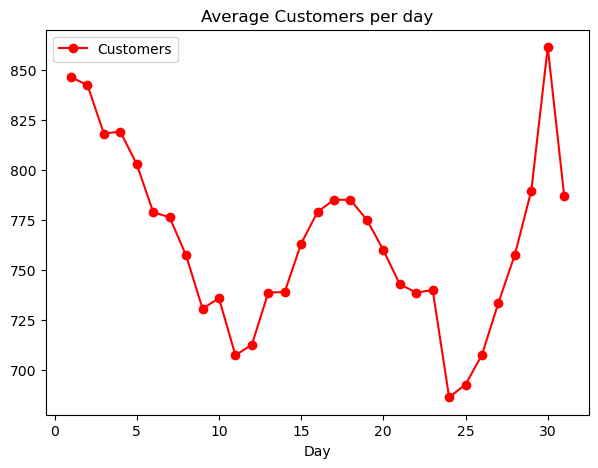

In [24]:
# checking sales with respect to months
axis = sales_df.groupby('Month')[['Sales']].mean().plot(figsize= (7, 5), marker = 'o', color = 'r')
axis.set_title('Average sales per month')

# checking Customers with respect to months
axis = sales_df.groupby('Month')[['Customers']].mean().plot(figsize= (7, 5), marker = 'o', color = 'r')
axis.set_title('Average customers per month')

# checking sales with respect to day
axis = sales_df.groupby('Day')[['Sales']].mean().plot(figsize= (7, 5), marker = 'o', color = 'r')
axis.set_title('Average sales per day')

# checking sales with respect to day
axis = sales_df.groupby('Day')[['Customers']].mean().plot(figsize= (7, 5), marker = 'o', color = 'r')
axis.set_title('Average Customers per day')

Text(0.5, 1.0, 'Average customers per day of a week')

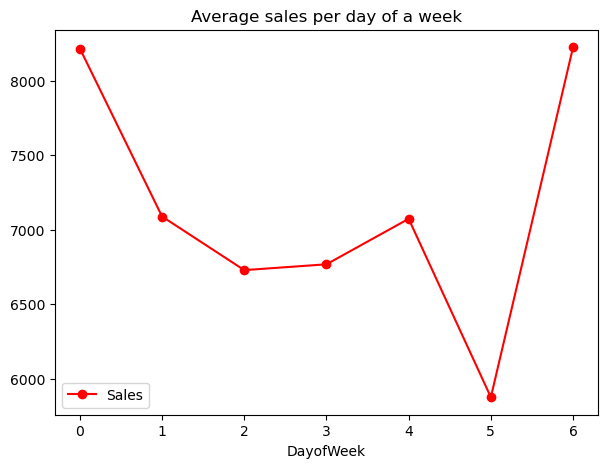

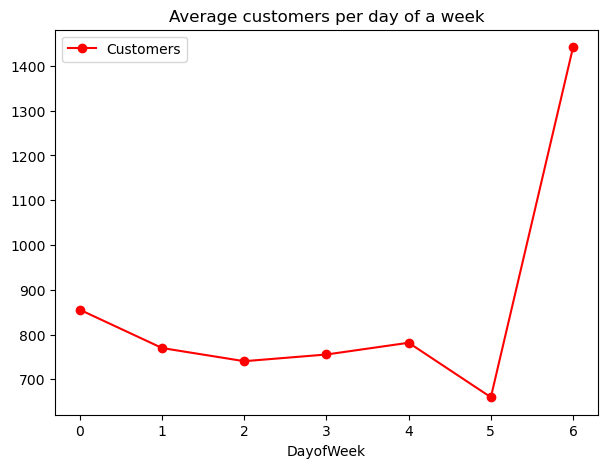

In [25]:
# checking sales with respect to day of week
axis = sales_df.groupby('DayofWeek')[['Sales']].mean().plot(figsize= (7, 5), marker = 'o', color = 'r')
axis.set_title('Average sales per day of a week')

# checking customers with respect to day of week
axis = sales_df.groupby('DayofWeek')[['Customers']].mean().plot(figsize= (7, 5), marker = 'o', color = 'r')
axis.set_title('Average customers per day of a week')

C:\Users\iamni\AppData\Local\Temp\ipykernel_13832\620673482.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  sales_df.groupby(['Date','StoreType']).mean()['Sales'].unstack().plot(ax =ax)


<Axes: xlabel='Date'>

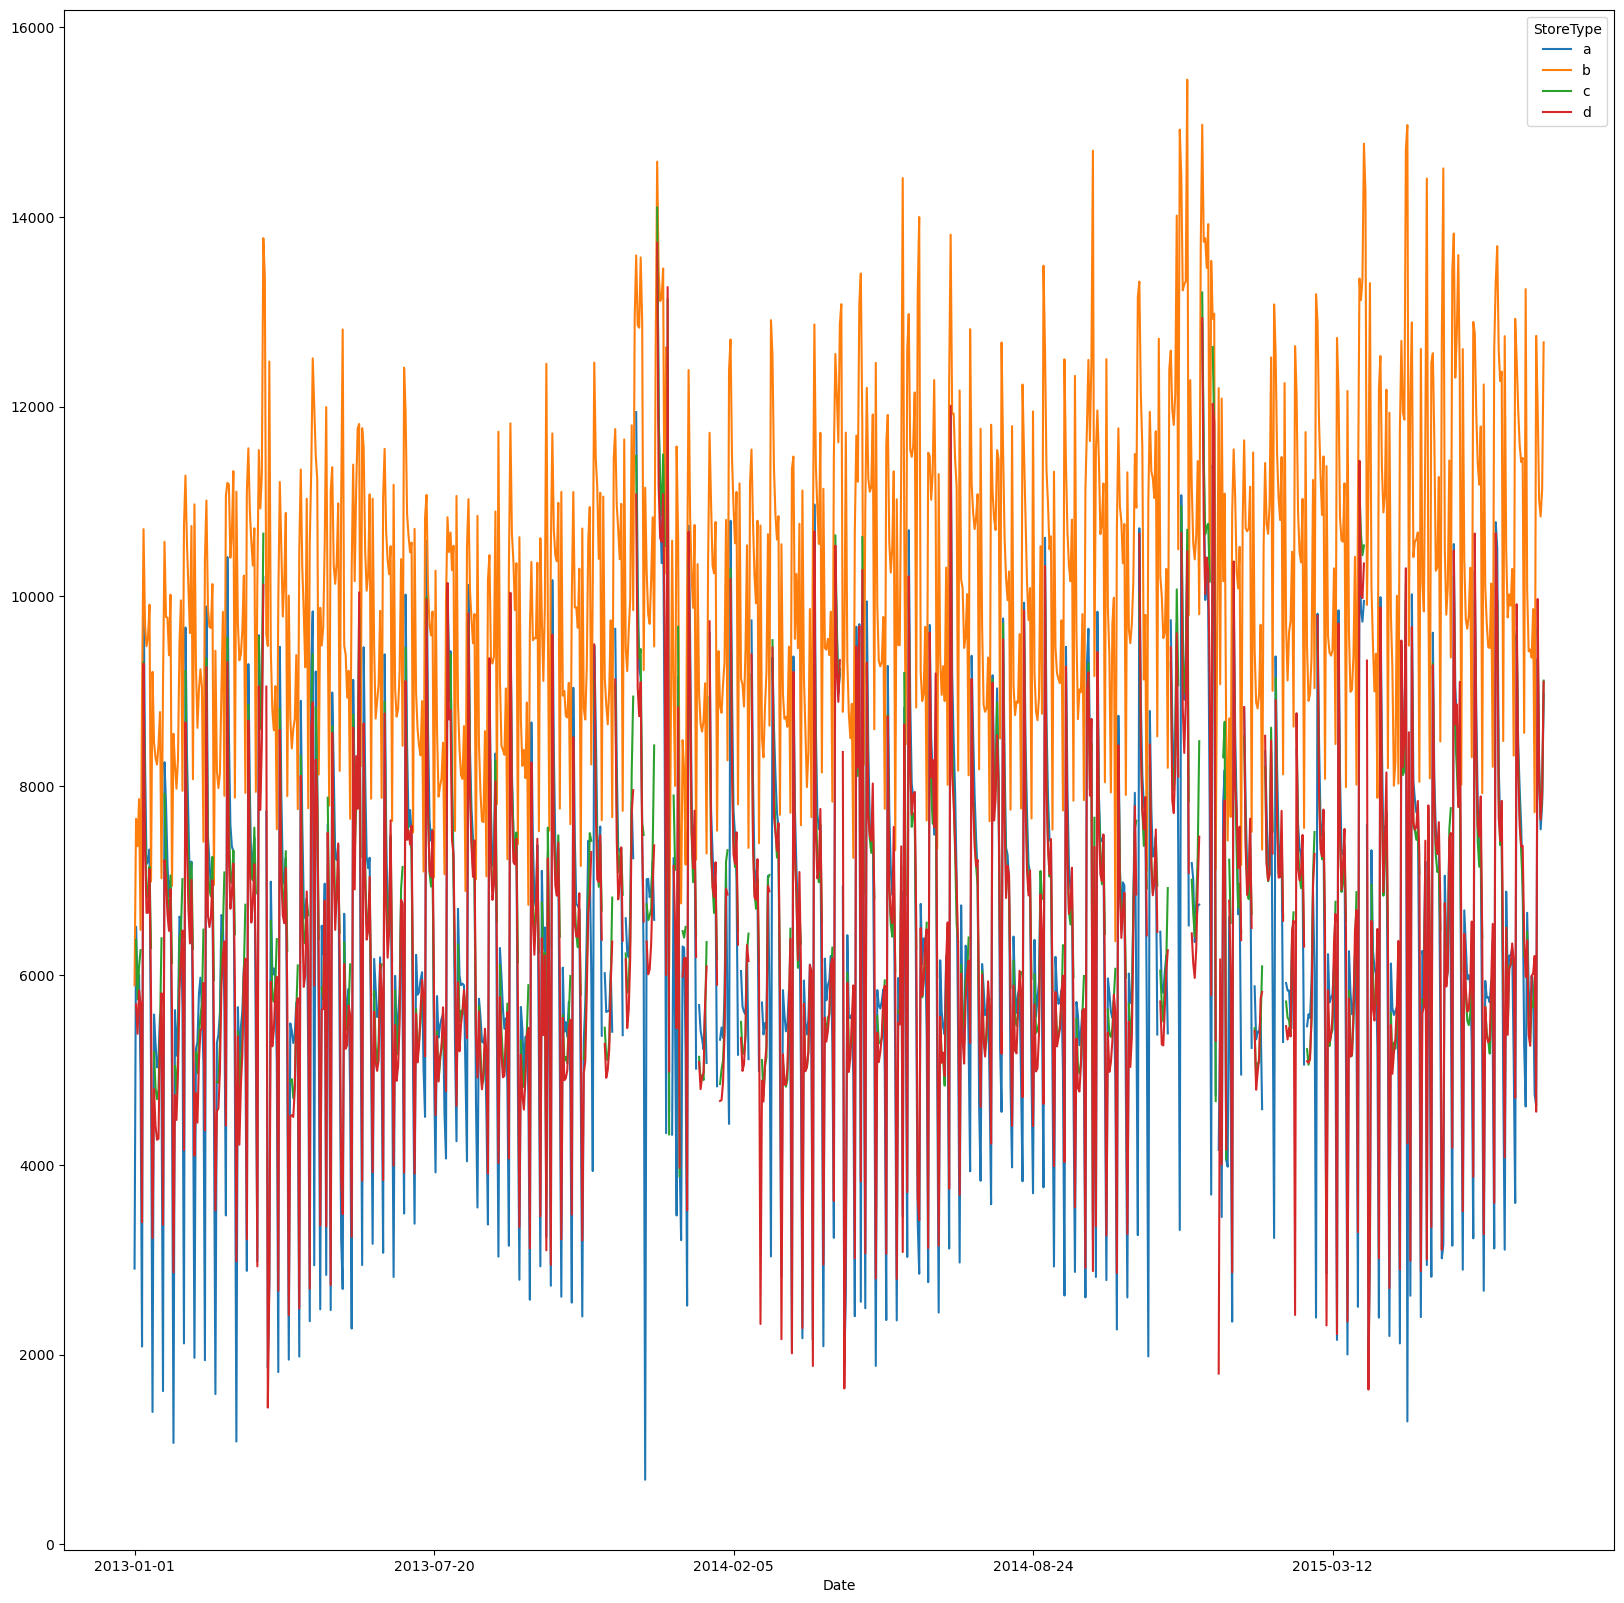

In [26]:
#checking sales with respect to store type
fig, ax = plt.subplots(figsize = (20,20))
sales_df.groupby(['Date','StoreType']).mean()['Sales'].unstack().plot(ax =ax)

<Axes: xlabel='Promo', ylabel='Sales'>

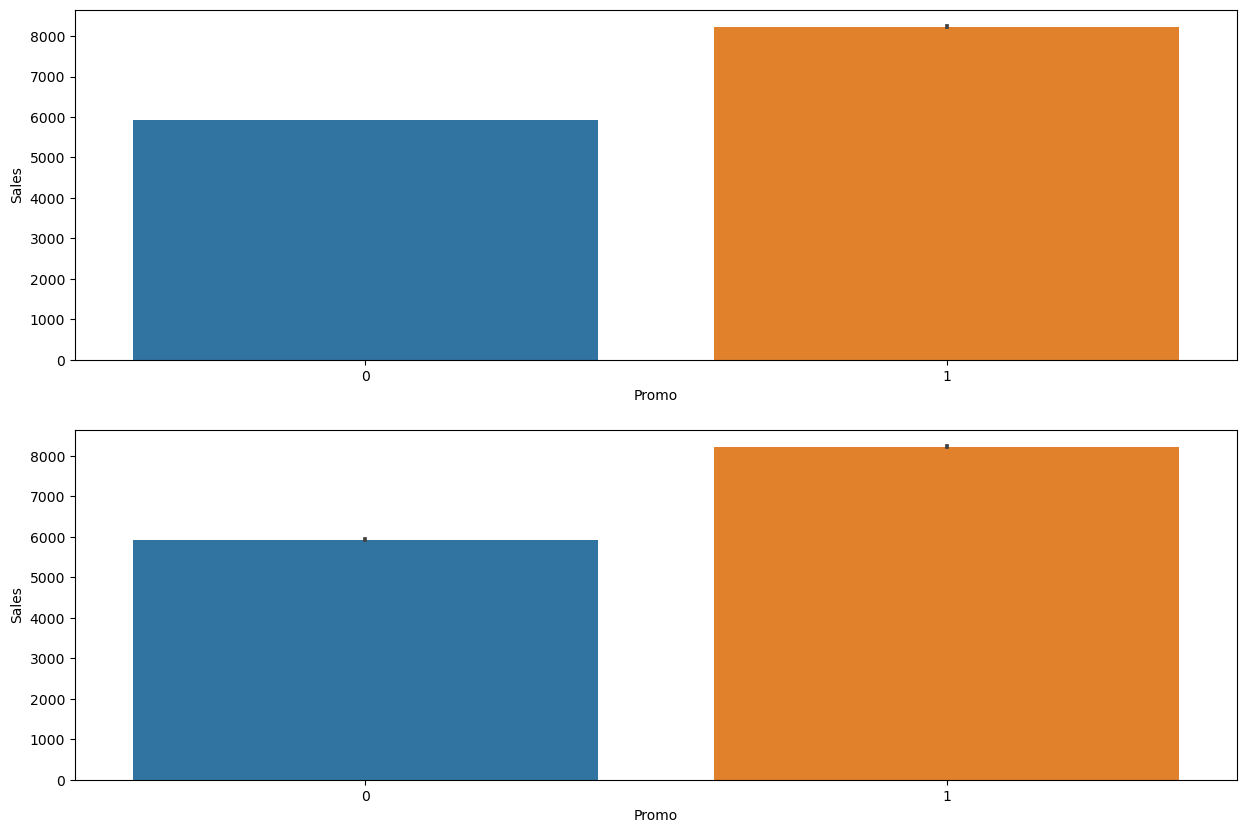

In [27]:
#checking promo effect on sales
plt.figure(figsize = (15,10))

plt.subplot(211)
sns.barplot(x = 'Promo', y = 'Sales', data = sales_df)

plt.subplot(212)
sns.barplot(x = 'Promo', y = 'Sales', data = sales_df)

<Axes: xlabel='Promo', ylabel='Sales'>

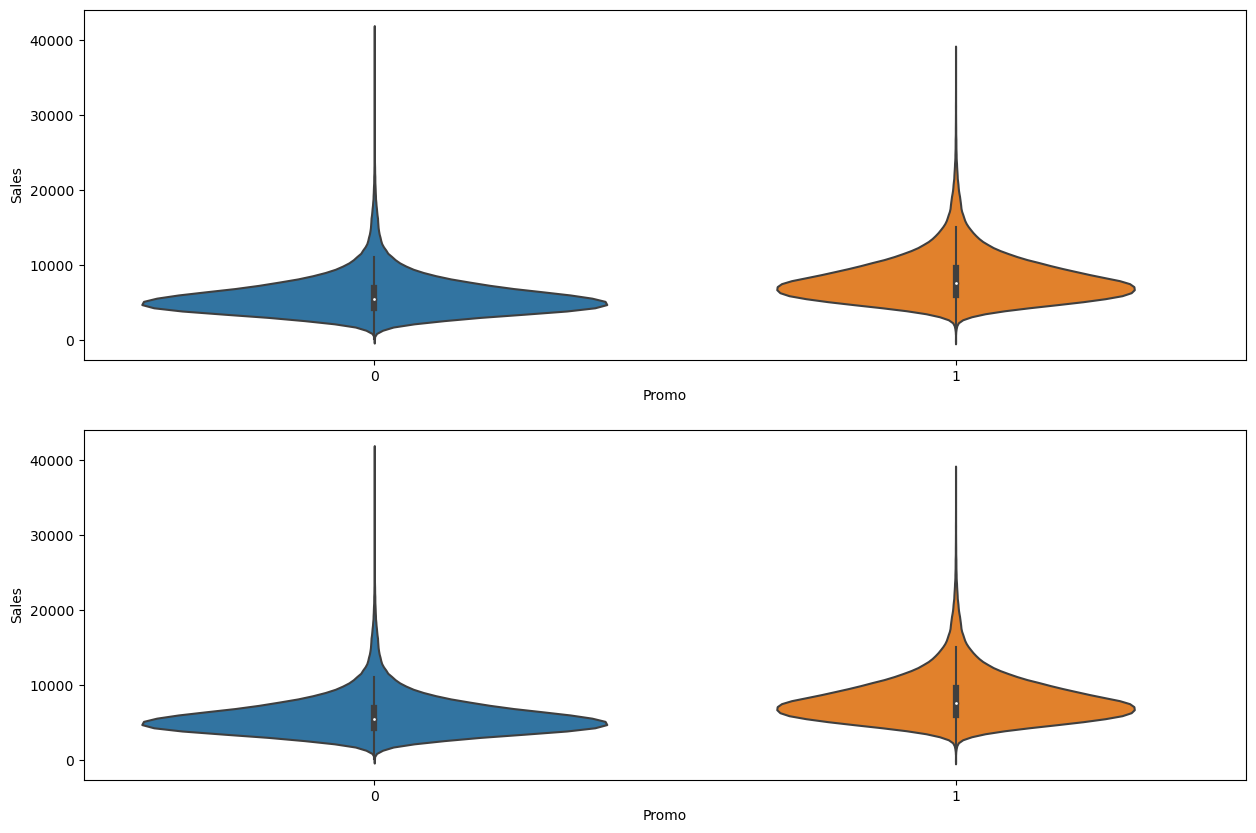

In [28]:
plt.figure(figsize = (15,10))

plt.subplot(211)
sns.violinplot(x = 'Promo', y = 'Sales', data = sales_df)

plt.subplot(212)
sns.violinplot(x = 'Promo', y = 'Sales', data = sales_df)

using
### Facebook Prophet
to make predictions

In [29]:
from prophet import Prophet

In [30]:
def sales_prediction(store_id, sale_df, periods):
    
    sale_df = sale_df[sale_df['Store'] == store_id]
    sale_df = sale_df[['Date', 'Sales']].rename(columns = {'Date': 'ds', 'Sales': 'y'})
    sale_df = sale_df.sort_values('ds')
    
    model = Prophet()
    model.fit(sale_df)
    future = model.make_future_dataframe(periods = periods)
    forecast = model.predict(future)
    figure1 = model.plot(forecast, xlabel = 'Date', ylabel = 'Sales')
    figure2 = model.plot_components(forecast)

17:40:54 - cmdstanpy - INFO - Chain [1] start processing
17:40:54 - cmdstanpy - INFO - Chain [1] done processing


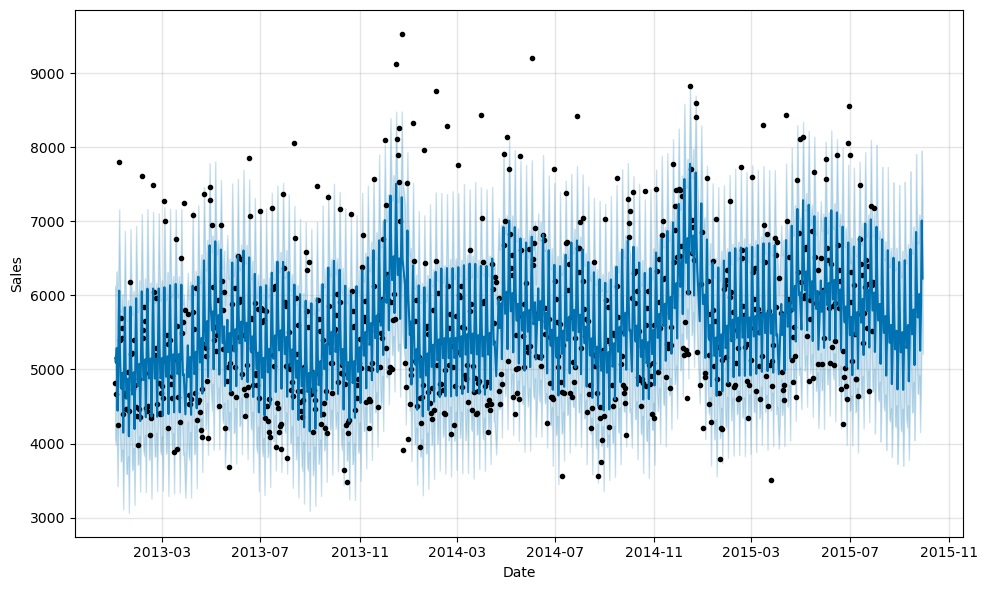

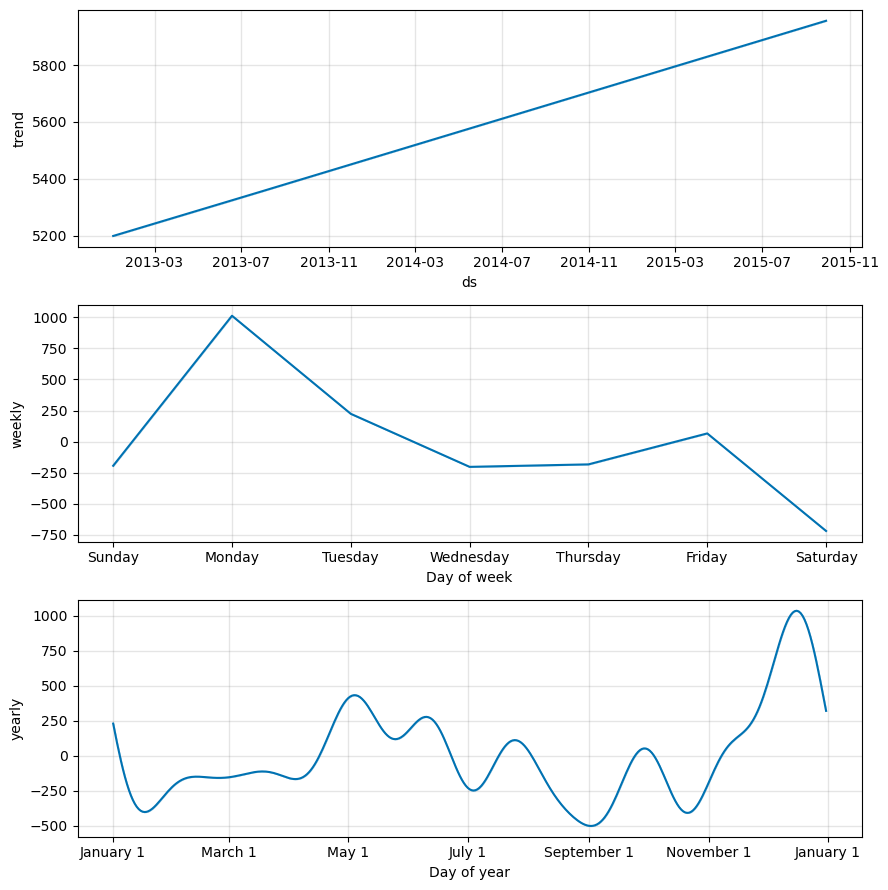

In [31]:
sales_prediction(10, sales_df, 60)

In [32]:
#making predictions with holidays included
def sales_prediction_h(store_id, sale_df, periods, holidays):
    
    sale_df = sale_df[sale_df['Store'] == store_id]
    sale_df = sale_df[['Date', 'Sales']].rename(columns = {'Date': 'ds', 'Sales': 'y'})
    sale_df = sale_df.sort_values('ds')
    
    model = Prophet(holidays = holidays)
    model.fit(sale_df)
    future = model.make_future_dataframe(periods = periods)
    forecast = model.predict(future)
    figure1 = model.plot(forecast, xlabel = 'Date', ylabel = 'Sales')
    figure2 = model.plot_components(forecast)

In [33]:
sales_train_all_df = sales_df
school_holidays = sales_train_all_df[sales_train_all_df['SchoolHoliday'] == 1].Date.unique()
school_holidays.sort()
 
state_holidays = sales_train_all_df[(sales_train_all_df['StateHoliday'] != '0') & (sales_train_all_df['StateHoliday'] != 0)].Date.unique()
state_holidays.sort()
 
school_holidays_df = pd.DataFrame({'ds': school_holidays, 'holiday':'school_holiday'})
state_holidays_df = pd.DataFrame({'ds': state_holidays, 'holiday':'state_holiday'})
 
holiday_df = pd.concat((school_holidays_df, state_holidays_df))

In [34]:
holiday_df

,ds,holiday
0,2013-01-01,school_holiday
1,2013-01-02,school_holiday
2,2013-01-03,school_holiday
3,2013-01-04,school_holiday
4,2013-01-05,school_holiday
...,...,...
30,2015-04-06,state_holiday
31,2015-05-01,state_holiday
32,2015-05-14,state_holiday
33,2015-05-25,state_holiday


17:40:56 - cmdstanpy - INFO - Chain [1] start processing
17:40:56 - cmdstanpy - INFO - Chain [1] done processing


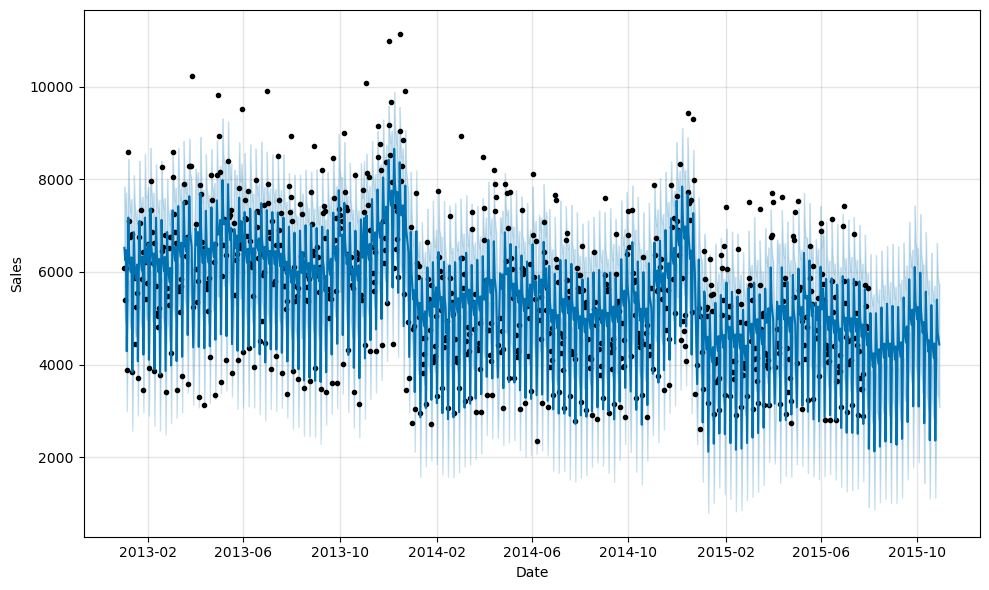

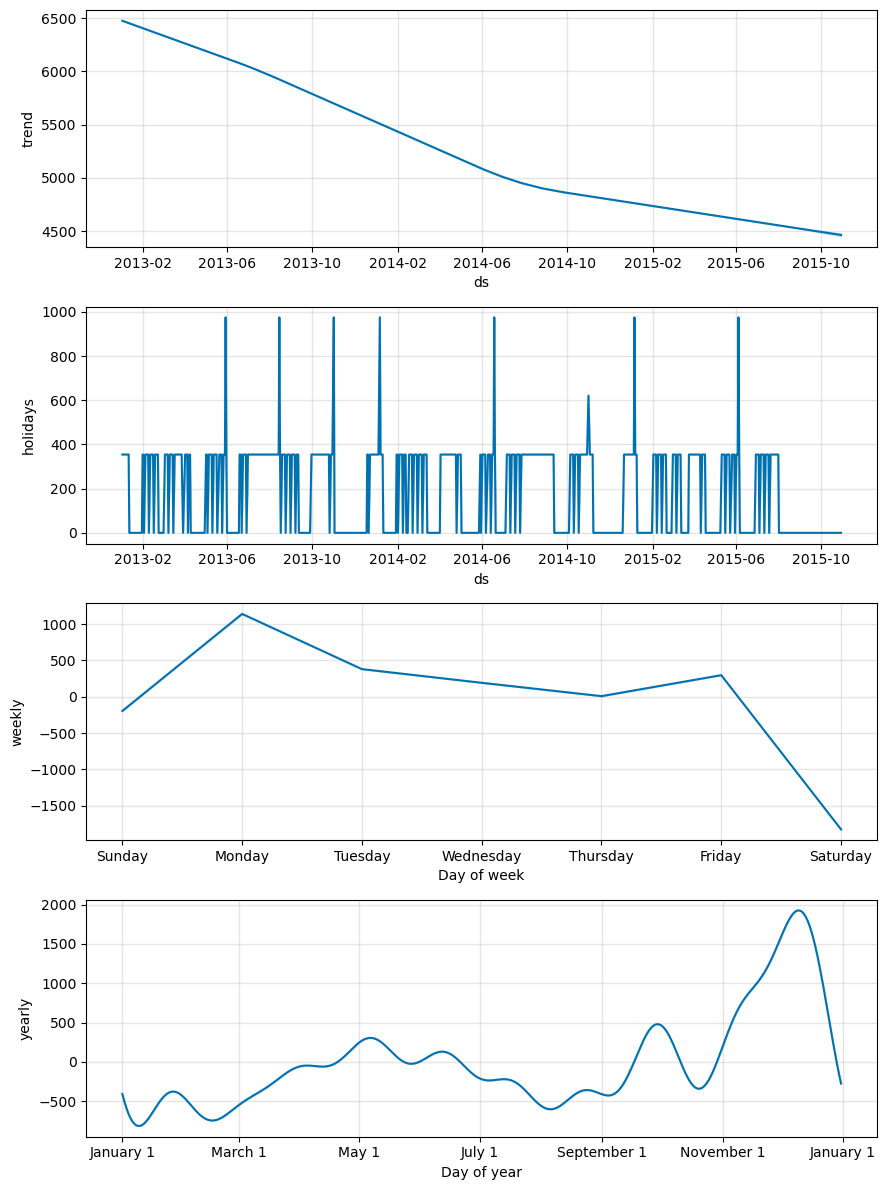

In [35]:
sales_prediction_h(6, sales_df, 90, holiday_df)